In [1]:
from google.colab import auth, files, drive
auth.authenticate_user()
print('Authenticated')

Authenticated


In [2]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns

from google.cloud import bigquery
client = bigquery.Client(project='datafall-fulfillment')
date = datetime.strftime(datetime.now(), "%m%d%y")

In [3]:
query= """SELECT * FROM (
  
SELECT *, courier_uuid, market_id, total_earnings/total_active_time as earn_hour,  total_deliveries/total_active_time as deliveries_hour FROM 
(SELECT courier_uuid, market_id, sum(base_earnings) as total_earnings, sum(total_gps_time)/60 as total_active_time, sum(num_deliveries) as total_deliveries, sum(tip_earnings) as tips, 
sum(incentives_earnings) as incentives from `datafall-fulfillment.xlavenir_sandbox.courier_sessions_v6` 

GROUP BY courier_uuid, market_id) as tot_time
WHERE total_active_time>0 ) AS t
WHERE earn_hour>18.7;"""

df = client.query(query).to_dataframe()

The dataframe is grouped by courier id, so each row contains information about total deliveries completed by a driver along with his or her total earnings, tips, and active time. Note: we only filtered out high-earnings drivers with income higher than $18.2 $/hour.

To start, we exclude market 73 (Mexico city) and calculate 1) tips' percentage of total postmate's earnings 2). average tip per delivery.

In [4]:
df=df[df['market_id']!=73]
df['perc_tips_earnings']=df['tips'].astype(float)/df['total_earnings']
df['tips_delivery']=df['tips']/df['total_deliveries']

Our next step to visualize tips earnings.


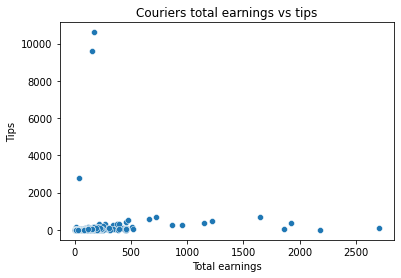

In [5]:
g=sns.scatterplot(data=df, x='total_earnings', y="tips")
plt.xlabel("Total earnings")
plt.ylabel("Tips")
plt.title("Couriers total earnings vs tips")
plt.show(g)

While it's reasonable that tips amount is correlated with total earnings, we observe three outlying observations with exceptionally high percentage of tips. Let's approach it from a different perspective and plot tips per delivery vs total earnings.

In [6]:
import plotly.express as px
fig = px.scatter(df, x="total_earnings", y="tips_delivery", hover_data=['courier_uuid'])
fig.show()

From two graphs above we can observe three drivers with very high percentage of tips out of their total earnings along with high tips per delivery (~$200).

In [7]:
couriers=df[df['perc_tips_earnings']>60]['courier_uuid']

query= """
  
SELECT * FROM `datafall-fulfillment.xlavenir_sandbox.courier_sessions_v6` 
WHERE courier_uuid='ecc08fb9-a014-460e-b18e-a2f5c7b3d7f1' or courier_uuid='696b6cc4-44ac-4f55-b54f-c4220dbea670' or courier_uuid='55474e85-ce2d-4461-840f-14720be7723a' """

df1 = client.query(query).to_dataframe()


In [8]:
avg_tips=np.mean(df1['tip_earnings'].astype("float") / df1['earnings'].astype("float"))
print ('For these drivers', np.round(avg_tips*100,0), '% of their income comes from the tips')

For these drivers 82.0 % of their income comes from the tips


Let's not see in what markets these drivers operate and how many deliveries each of them have completed. 


Text(0.5, 1.0, 'Deliveries across markets')

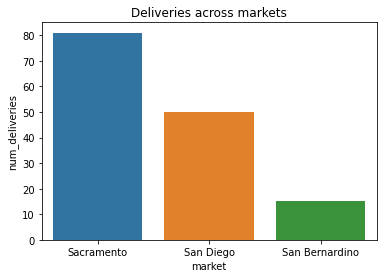

In [9]:
markets=df1.groupby(['market'])['num_deliveries'].agg('sum').reset_index().sort_values(by='num_deliveries', ascending=False)
sns.barplot(x="market", y="num_deliveries", data=markets)
plt.title("Deliveries across markets")

In [10]:
couriers = """SELECT * FROM datafall-fulfillment.model_v0.fct_deliveries_v0 WHERE courier_uuid='ecc08fb9-a014-460e-b18e-a2f5c7b3d7f1' or courier_uuid='55474e85-ce2d-4461-840f-14720be7723a' 
or courier_uuid='696b6cc4-44ac-4f55-b54f-c4220dbea670' """
couriers = client.query(couriers).to_dataframe()

In [11]:
print ('Are any of the completed deliveries part of chain or a batch?', np.unique(couriers.is_chain), np.unique(couriers.is_batch))
print ('What\'s the vehicle type?', np.unique(couriers.vehicle_type))

Are any of the completed deliveries part of chain or a batch? [False] [False]
What's the vehicle type? ['bicycle']


None of the completed deliveries are part of a chaining or batching and all of them are delivered by bike.

In [12]:
df3=pd.DataFrame(columns=['pickup', 'dropoff'])
pickups=[]
dropoffs=[]

for index, row in couriers.iterrows(): 
  pickups.append(couriers['waypoint_details'][index][0]['waypoint_uuid'])
  dropoffs.append(couriers['waypoint_details'][index][1]['waypoint_uuid'])
df3['pickup']=pickups
df3['dropoff']=dropoffs

df3['pickup']=df3.pickup.str.replace('pickup:', '')
df3['dropoff']=df3.dropoff.str.replace('dropoff:', '')
df3[df3['pickup']!=df3['dropoff']]

,pickup,dropoff


For all of the deliveries, pick up and dropoff location were exactly the same.

In [13]:
print ('All of these deliveries were completed between', np.min(couriers['delivery_assign_ts']), 'and ', np.max(couriers['delivery_assign_ts']))

All of these deliveries were completed between 2019-08-13 11:01:44+00:00 and  2019-08-25 11:09:29+00:00


Now let's see who are the customers who is placing these orders.

In [14]:
deliveries=couriers.delivery_uuid	
q3="""SELECT delivery_uuid, customer_id FROM datafall-fulfillment.mark_sandbox.delivery_payloads WHERE job_date>='2019-08-13' and  job_date<='2019-08-25'"""
customers = client.query(q3).to_dataframe()
fraud=couriers.merge(customers, on='delivery_uuid', how='left')
fraud=fraud[['delivery_uuid','courier_uuid','customer_id']]

In [15]:
print ('All of these deliveries were placed by one customer:', np.unique(fraud['customer_id']))

All of these deliveries were placed by one customer: [8423065]


Based on everything described above, we suspect that these are fraudulent transactions. While the company was not affected, we still may want to investigate this kind of fraudulent activity further.